In [ ]:
import pandas as pd
import numpy as np
from io import StringIO

# 原始數據
data = '''log_len	addr	logs	fts	lts	sizes	lens	ultras	flushes	indices
2	764681	131_340	1277037_1277037	1277160_1277160	16_16	4_4	1_1	0_0	3142343_13624953
2	764787	132_341	1277665_1277665	1276821_1276821	16_16	4_4	1_1	0_0	3213834_13696444
2	764788	132_341	1277658_1277658	1276781_1276781	16_16	4_4	1_1	0_0	3213834_13696442
2	764789	132_341	1277614_1277614	1276681_1276681	16_16	4_4	1_1	0_0	3213835_13696443
2	764789	132_341	1276668_1276668	1276838_1276838	16_16	4_4	1_1	0_0	3213835_13696445
2	767943	132_341_22	1276668_1276668_22	1276838_1276838_22	16_16_16	4_4_4	1_1_1	0_0_0	3213835_13696445_22
2	767943	132_341_22_24	1276668_1276668_22_24	1276838_1276838_22_24	16_16_16_16	4_4_4_4	1_1_1_1	0_0_0_0	3213835_13696445_22_24'''

# 將字符串轉換為 DataFrame
df = pd.read_csv(StringIO(data), sep='\t')

# 定義需要拆分的欄位
columns_to_split = ['logs', 'fts', 'lts', 'sizes', 'lens', 'ultras', 'flushes', 'indices']

# 創建新的 DataFrame
result_df = pd.DataFrame()

# 複製原始的非拆分欄位
result_df['log_len'] = df['log_len']
result_df['addr'] = df['addr']

# 處理每個需要拆分的欄位
for col in columns_to_split:
    # 找出最大的分割數
    max_parts = df[col].str.count('_').max() + 1
    
    # 拆分每個欄位
    for i in range(max_parts):
        # 創建新的欄位名稱
        new_col = f'{col}_part{i+1}'
        
        # 拆分並取得對應的部分
        result_df[new_col] = df[col].apply(
            lambda x: x.split('_')[i] if isinstance(x, str) and i < len(x.split('_')) else None
        ).astype(float)  # 轉換為數值類型

    # 計算差值
    for i in range(max_parts-1):
        part1_col = f'{col}_part{i+1}'
        part2_col = f'{col}_part{i+2}'
        diff_col = f'{col}_diff{i+1}_{i+2}'
        
        if part1_col in result_df.columns and part2_col in result_df.columns:
            result_df[diff_col] = result_df[part2_col] - result_df[part1_col]

# 顯示前幾行和列名
print("DataFrame 的列名:")
print(result_df.columns.tolist())
print("\n所有資料:")
print(result_df)

# 保存到 Excel 檔案
result_df.to_excel('split_data.xlsx', index=False)
print("\n資料已保存到 'split_data.xlsx'")

# 顯示基本統計信息
print("\n資料維度:", result_df.shape)
print("\n非空值數量:")
print(result_df.count())

In [71]:
import pandas as pd
import numpy as np

def process_excel_data(input_file, columns_to_split, percentage=1):
    """
    讀取 Excel 檔案，拆分欄位並計算差值
    
    參數:
    input_file (str): Excel 檔案路徑
    columns_to_split (list): 需要拆分的欄位名稱列表
    percentage (float): 要保留的資料比例 (0-1)
    """
    # 讀取 Excel 檔案
    df = pd.read_excel(input_file)
    
    # 計算要保留的行數
    n_rows = int(len(df) * percentage)
    
    # 只保留前 n_rows 行
    df = df.head(n_rows)
    
    def split_values(value):
        """將字串依底線拆分"""
        if pd.isna(value):
            return pd.Series([])
        
        # 拆分字串
        parts = str(value).split('_')
        
        # 轉換所有部分為數值
        parts = [pd.to_numeric(p, errors='coerce') for p in parts]
        
        # 建立結果字典
        result = {}
        
        # 儲存所有部分
        for i, part in enumerate(parts):
            result[f'part{i+1}'] = part
            
        return pd.Series(result)
    
    # 處理每個指定欄位的拆分
    result_df = df.copy()
    
    for col in columns_to_split:
        if col in df.columns:
            # 找出這個欄位中最多的分割數
            max_splits = df[col].astype(str).str.count('_').max() + 1
            
            # 拆分
            split_results = df[col].apply(split_values)
            
            # 將結果加入到 DataFrame
            for new_col in split_results.columns:
                result_df[f'{col}_{new_col}'] = split_results[new_col]
            
            # 刪除原始欄位
            result_df.drop(columns=[col], inplace=True)
    
    # 計算差值
    columns = result_df.columns
    base_columns = set()
    
    # 找出基礎欄位名稱
    for col in columns:
        if '_part' in col:
            base_name = col.split('_part')[0]
            base_columns.add(base_name)
    
    # 處理每個基礎欄位的差值計算
    for base in base_columns:
        # 找出此基礎欄位的所有 parts
        part_cols = [col for col in columns if col.startswith(f'{base}_part')]
        max_part = len(part_cols)
        
        # 計算相鄰 parts 之間的差值
        for i in range(max_part - 1):
            part1 = f'{base}_part{i+1}'
            part2 = f'{base}_part{i+2}'
            if part1 in result_df.columns and part2 in result_df.columns:
                diff_col = f'{base}_diff{i+1}_{i+2}'
                result_df[diff_col] = result_df[part2] - result_df[part1]
    
    return result_df

if __name__ == "__main__":
    # 設定檔案路徑和要處理的欄位
    input_file = "C:/Users/user/OneDrive/桌面/e3_burst.xlsx"
    columns_to_split = ["logs", "fts", "lts", "sizes", "lens", "ultras", "flushes", "indices"]
    
    # 處理資料
    processed_df = process_excel_data(input_file, columns_to_split, percentage=1)
    
    # 顯示結果
    print(processed_df)
    
    # 儲存結果
    processed_df.to_excel("output_final.xlsx", index=False)
    
    print("\n資料處理完成，已儲存至 'output_final.xlsx'")
    print(f"原始資料行數: {len(pd.read_excel(input_file))}")
    print(f"處理後資料行數: {len(processed_df)}")

   log_len    addr  logs_part1  logs_part2  logs_part3  logs_part4  fts_part1  \
0        2  764681       131.0       340.0         NaN         NaN  1277037.0   
1        2  764787       132.0       341.0         NaN         NaN  1277665.0   
2        2  764788       132.0       341.0         NaN         NaN  1277658.0   
3        2  764789       132.0       341.0         NaN         NaN  1277614.0   
4        2  764789       132.0       341.0         NaN         NaN  1276668.0   
5        2  767943       132.0       341.0        22.0         NaN  1276668.0   
6        2  767943       132.0       341.0        22.0        24.0  1276668.0   

   fts_part2  fts_part3  fts_part4  ...  fts_diff3_4  sizes_diff1_2  \
0  1277037.0        NaN        NaN  ...          NaN            0.0   
1  1277665.0        NaN        NaN  ...          NaN            0.0   
2  1277658.0        NaN        NaN  ...          NaN            0.0   
3  1277614.0        NaN        NaN  ...          NaN            0.0

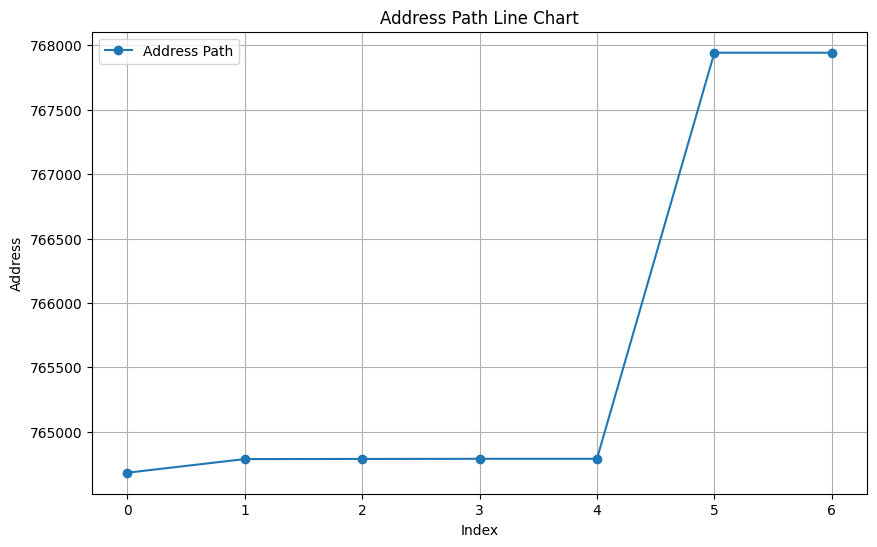

In [63]:
    # 畫 addr 的路線圖
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(processed_df['addr'], marker='o', linestyle='-', label='Address Path')
    plt.title('Address Path Line Chart')
    plt.xlabel('Index')
    plt.ylabel('Address')
    plt.grid(True)
    plt.legend()
    plt.show()

圖表已儲存為 'route_visualization_all_points.png'

數據點的值：

Point 1:
logs_part1: 131.0
logs_part2: 340.0

Point 2:
logs_part1: 132.0
logs_part2: 341.0

Point 3:
logs_part1: 132.0
logs_part2: 341.0

Point 4:
logs_part1: 132.0
logs_part2: 341.0

Point 5:
logs_part1: 132.0
logs_part2: 341.0

Point 6:
logs_part1: 132.0
logs_part2: 341.0
logs_part3: 22.0

Point 7:
logs_part1: 132.0
logs_part2: 341.0
logs_part3: 22.0
logs_part4: 24.0


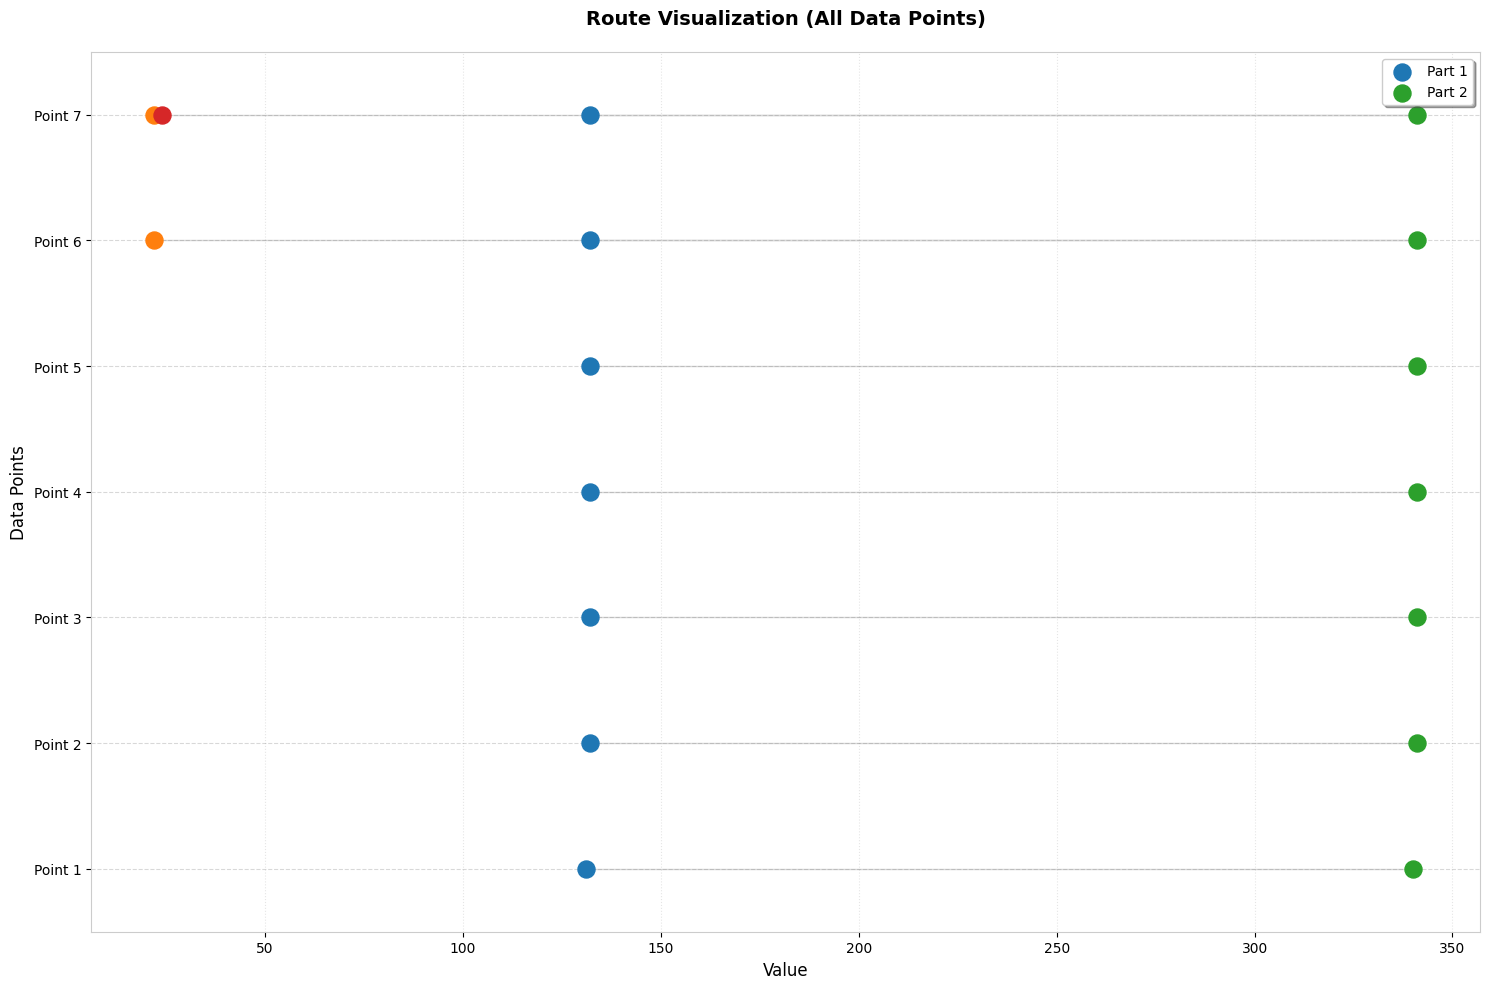

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_route(input_file):
    """
    繪製所有數據點的路線圖，包含所有可用的parts
    
    參數:
    input_file (str): Excel 檔案路徑
    """
    # 讀取 Excel 檔案
    df = pd.read_excel(input_file)
    
    # 選擇所有需要的部分
    part_cols = ['logs_part1', 'logs_part2', 'logs_part3', 'logs_part4']
    
    # 創建圖表和軸
    fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
    ax.set_facecolor('white')
    
    # 設置顏色
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']  # 藍、綠、橙、紅
    
    # 為每一行數據繪製路線
    for row_idx, row in df.iterrows():
        # 獲取該行中非NaN的數據點
        valid_parts = []
        valid_values = []
        
        for idx, col in enumerate(part_cols):
            if pd.notna(row[col]):
                valid_parts.append(idx + 1)
                valid_values.append(row[col])
        
        if len(valid_values) > 0:
            # 繪製連接線（如果有多個點）
            if len(valid_values) > 1:
                ax.plot(valid_values, [row_idx] * len(valid_values),
                       '-', color='gray', alpha=0.3, linewidth=1,
                       zorder=1)
            
            # 繪製每個點
            for part_idx, value in zip(valid_parts, valid_values):
                ax.scatter(value, row_idx,
                         color=colors[part_idx-1],
                         s=150,
                         label=f'Part {part_idx}' if row_idx == 0 else "",
                         zorder=2)
    
    # 設置Y軸範圍和標籤
    ax.set_ylim(-0.5, len(df)-0.5)
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels([f'Point {i+1}' for i in range(len(df))])
    
    # 設置圖表標題和標籤
    ax.set_title('Route Visualization (All Data Points)', 
                fontsize=14, pad=20, fontweight='bold')
    ax.set_xlabel('Value', fontsize=12)
    ax.set_ylabel('Data Points', fontsize=12)
    
    # 設置刻度標籤的字體大小
    ax.tick_params(axis='both', labelsize=10)
    
    # 添加圖例（只顯示唯一的標籤）
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),
             loc='upper right',
             frameon=True,
             fancybox=True,
             shadow=True)
    
    # 添加網格
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # 設置邊框顏色
    for spine in ax.spines.values():
        spine.set_color('#CCCCCC')
    
    # 添加垂直線以便於觀察對齊
    ax.grid(True, which='major', axis='x', linestyle=':', alpha=0.2)
    
    # 調整佈局
    plt.tight_layout()
    
    # 儲存圖表
    plt.savefig('route_visualization_all_points.png', 
                bbox_inches='tight',
                dpi=300,
                facecolor='white',
                edgecolor='none')
    print("圖表已儲存為 'route_visualization_all_points.png'")
    
    # 顯示點的具體值
    print("\n數據點的值：")
    for idx, row in df.iterrows():
        print(f"\nPoint {idx+1}:")
        for col in part_cols:
            if pd.notna(row[col]):
                print(f"{col}: {row[col]}")
    
    # 顯示圖表
    plt.show()

if __name__ == "__main__":
    # 設定輸入檔案路徑
    input_file = "output_final.xlsx"
    
    try:
        # 繪製路線圖
        plot_route(input_file)
    except Exception as e:
        print(f"發生錯誤: {str(e)}")
        # 打印更詳細的錯誤信息
        import traceback
        traceback.print_exc()

圖表已儲存為 'route_visualization_all_on_logs.png'

所有指標的數據點值和差值：

Point 1:

LOGS:
logs_part1: 131.0
logs_part2: 340.0
logs_diff1_2: 209.0

LTS:
lts_part1: 1277160.0
lts_part2: 1277160.0
lts_diff1_2: 0.0

FTS:
fts_part1: 1277037.0
fts_part2: 1277037.0
fts_diff1_2: 0.0

Point 2:

LOGS:
logs_part1: 132.0
logs_part2: 341.0
logs_diff1_2: 209.0

LTS:
lts_part1: 1276821.0
lts_part2: 1276821.0
lts_diff1_2: 0.0

FTS:
fts_part1: 1277665.0
fts_part2: 1277665.0
fts_diff1_2: 0.0

Point 3:

LOGS:
logs_part1: 132.0
logs_part2: 341.0
logs_diff1_2: 209.0

LTS:
lts_part1: 1276781.0
lts_part2: 1276781.0
lts_diff1_2: 0.0

FTS:
fts_part1: 1277658.0
fts_part2: 1277658.0
fts_diff1_2: 0.0

Point 4:

LOGS:
logs_part1: 132.0
logs_part2: 341.0
logs_diff1_2: 209.0

LTS:
lts_part1: 1276681.0
lts_part2: 1276681.0
lts_diff1_2: 0.0

FTS:
fts_part1: 1277614.0
fts_part2: 1277614.0
fts_diff1_2: 0.0

Point 5:

LOGS:
logs_part1: 132.0
logs_part2: 341.0
logs_diff1_2: 209.0

LTS:
lts_part1: 1276838.0
lts_part2: 1276838.0
lts_dif

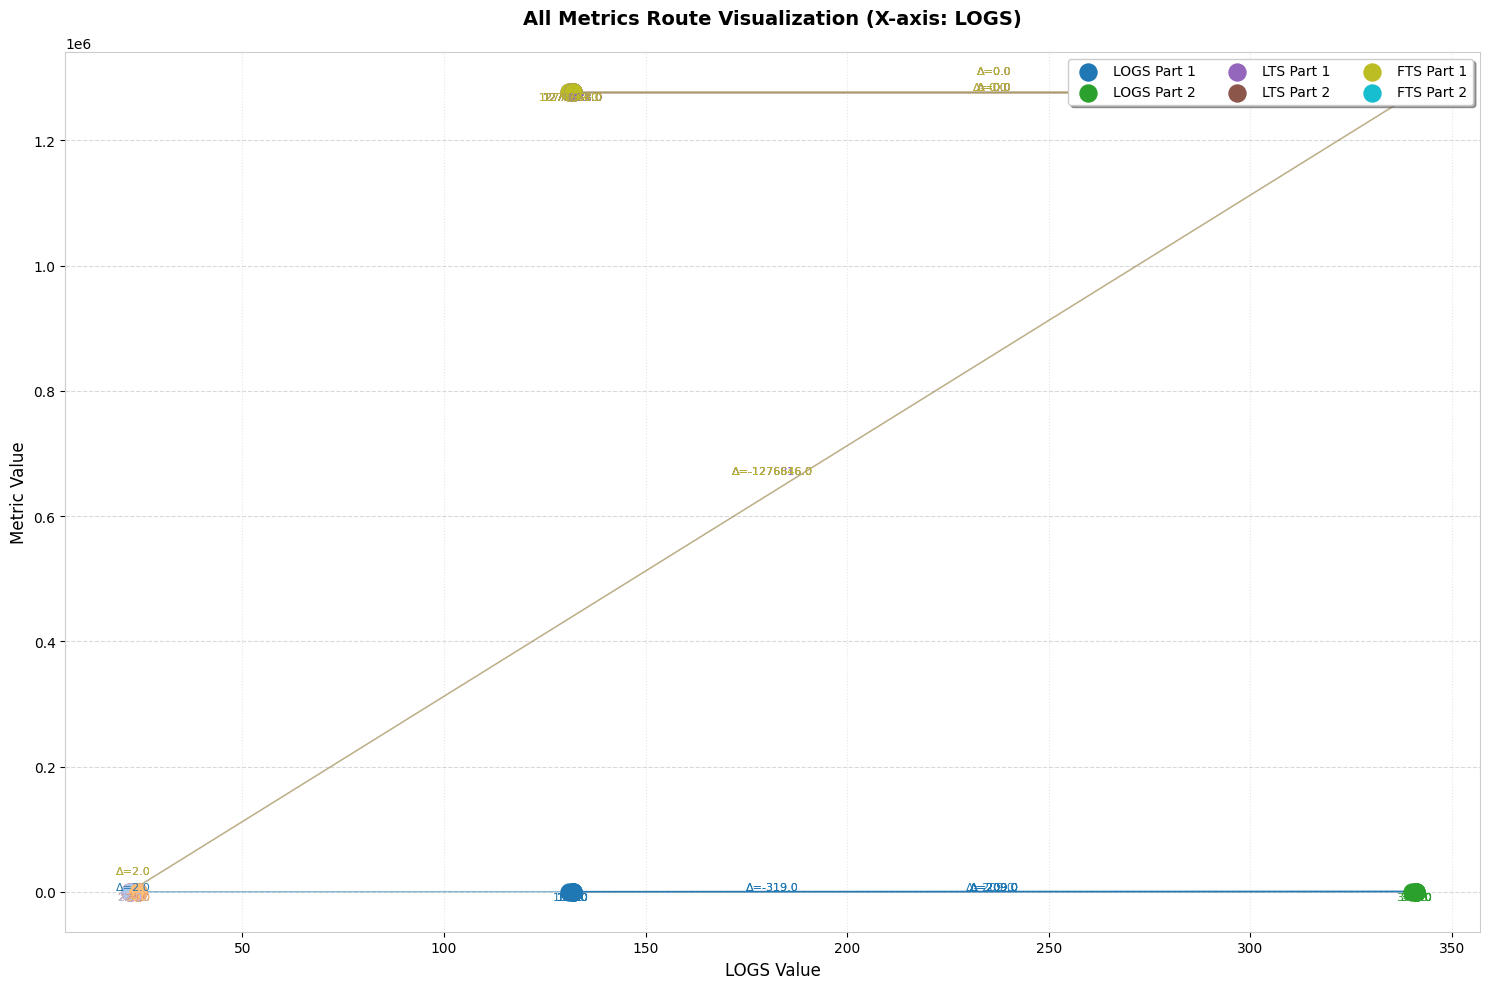

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_route(input_file):
    """
    繪製所有指標的路線圖，使用 LOGS 作為 X 軸
    """
    # 讀取 Excel 檔案
    df = pd.read_excel(input_file)
    
    # 創建圖表和軸
    fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
    ax.set_facecolor('white')
    
    # 設置顏色
    metric_colors = {
        'logs': ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728'],  # 藍、綠、橙、紅
        'lts': ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f'],   # 紫、棕、粉、灰
        'fts': ['#bcbd22', '#17becf', '#aec7e8', '#ffbb78']    # 黃、青、淺藍、淺橙
    }
    
    # 為每個指標繪製路線
    metrics = ['logs', 'lts', 'fts']
    
    for row_idx, row in df.iterrows():
        # 對每個指標進行繪製
        for metric in metrics:
            # 獲取該行中非NaN的數據點
            valid_parts = []
            valid_values = []
            valid_logs = []  # 對應的logs值
            
            # 遍歷每個part
            for i in range(1, 5):
                metric_col = f'{metric}_part{i}'
                logs_col = f'logs_part{i}'
                
                if metric_col in df.columns and logs_col in df.columns:
                    if pd.notna(row[metric_col]) and pd.notna(row[logs_col]):
                        valid_parts.append(i)
                        valid_values.append(row[metric_col])
                        valid_logs.append(row[logs_col])
            
            if len(valid_values) > 1:
                # 繪製連接線
                for i in range(len(valid_values)-1):
                    # 繪製連接線
                    ax.plot([valid_logs[i], valid_logs[i+1]], 
                           [valid_values[i], valid_values[i+1]],
                           '-', color=metric_colors[metric][0], alpha=0.3, linewidth=1,
                           zorder=1)
                    
                    # 獲取對應的diff值
                    diff_col = f'{metric}_diff{valid_parts[i]}_{valid_parts[i+1]}'
                    if diff_col in df.columns and pd.notna(row[diff_col]):
                        # 計算文字位置（在線段中間）
                        x_mid = (valid_logs[i] + valid_logs[i+1]) / 2
                        y_mid = (valid_values[i] + valid_values[i+1]) / 2
                        ax.text(x_mid, y_mid + (max(valid_values) - min(valid_values))*0.02, 
                               f'Δ={row[diff_col]}',
                               ha='center', va='bottom',
                               color=metric_colors[metric][0],
                               fontsize=8)
            
            # 繪製每個點
            for i, (log_val, value, part) in enumerate(zip(valid_logs, valid_values, valid_parts)):
                ax.scatter(log_val, value,
                         color=metric_colors[metric][part-1],
                         s=150,
                         label=f'{metric.upper()} Part {part}' if row_idx == 0 else "",
                         zorder=2)
                # 在點旁添加值標籤
                ax.text(log_val, value - (max(df[f'{metric}_part1'].dropna()) - min(df[f'{metric}_part1'].dropna()))*0.02,
                       f'{value}',
                       ha='center', va='top',
                       color=metric_colors[metric][part-1],
                       fontsize=8)
    
    # 設置圖表標題和標籤
    ax.set_title('All Metrics Route Visualization (X-axis: LOGS)', 
                fontsize=14, pad=20, fontweight='bold')
    ax.set_xlabel('LOGS Value', fontsize=12)
    ax.set_ylabel('Metric Value', fontsize=12)
    
    # 設置刻度標籤的字體大小
    ax.tick_params(axis='both', labelsize=10)
    
    # 添加圖例
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),
             loc='upper right',
             frameon=True,
             fancybox=True,
             shadow=True,
             ncol=3)  # 使用3列顯示圖例
    
    # 添加網格
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    ax.grid(True, which='major', axis='x', linestyle=':', alpha=0.2)
    
    # 設置邊框顏色
    for spine in ax.spines.values():
        spine.set_color('#CCCCCC')
    
    # 調整佈局
    plt.tight_layout()
    
    # 儲存圖表
    plt.savefig('route_visualization_all_on_logs.png', 
                bbox_inches='tight',
                dpi=300,
                facecolor='white',
                edgecolor='none')
    print("圖表已儲存為 'route_visualization_all_on_logs.png'")
    
    # 顯示所有點的值和差值
    print("\n所有指標的數據點值和差值：")
    for idx, row in df.iterrows():
        print(f"\nPoint {idx+1}:")
        for metric in metrics:
            print(f"\n{metric.upper()}:")
            for i in range(1, 5):
                col = f'{metric}_part{i}'
                if col in df.columns and pd.notna(row[col]):
                    print(f"{col}: {row[col]}")
            for i in range(1, 4):
                diff_col = f'{metric}_diff{i}_{i+1}'
                if diff_col in df.columns and pd.notna(row[diff_col]):
                    print(f"{diff_col}: {row[diff_col]}")
    
    # 顯示圖表
    plt.show()

if __name__ == "__main__":
    # 設定輸入檔案路徑
    input_file = "output_final.xlsx"
    
    try:
        # 繪製路線圖
        plot_route(input_file)
    except Exception as e:
        print(f"發生錯誤: {str(e)}")
        # 打印更詳細的錯誤信息
        import traceback
        traceback.print_exc()

圖表已儲存為 'route_visualization_all_points_updated.png'


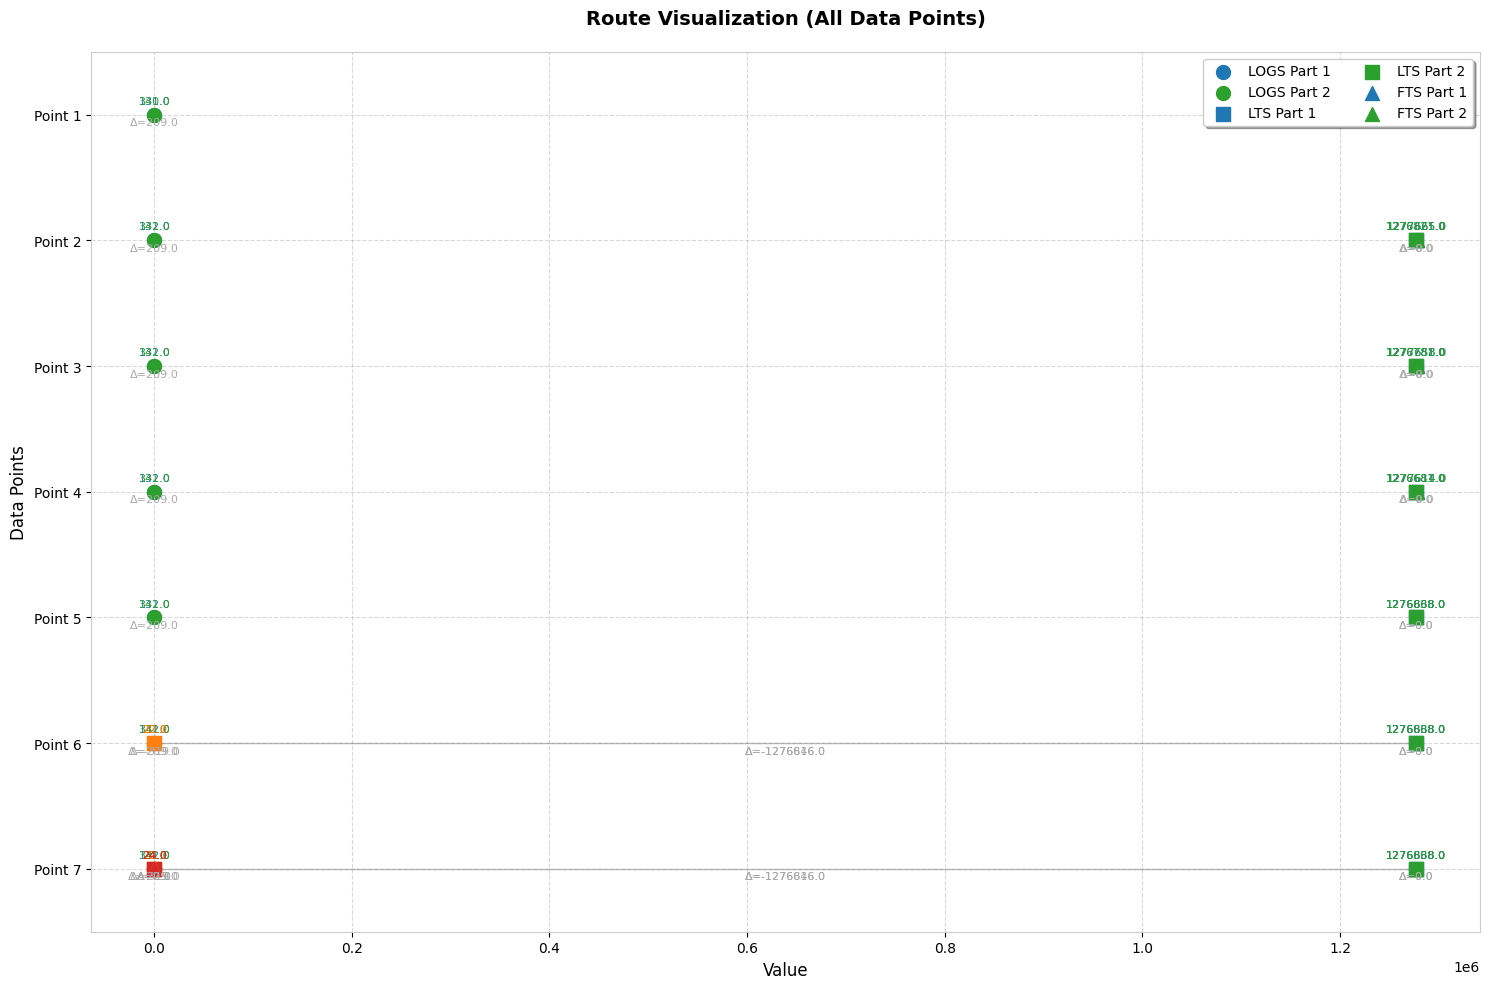

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_route(input_file):
    """
    繪製所有數據點的路線圖，使用類似的布局方式
    """
    # 讀取 Excel 檔案
    df = pd.read_excel(input_file)
    
    # 創建圖表和軸
    fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
    ax.set_facecolor('white')
    
    # 設置顏色
    colors = {
        'logs': ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728'],  # 藍、綠、橙、紅
        'lts': ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728'],   # 使用相同的顏色方案
        'fts': ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']    # 使用相同的顏色方案
    }
    
    # 為每個指標繪製路線
    metrics = ['logs', 'lts', 'fts']
    markers = {'logs': 'o', 'lts': 's', 'fts': '^'}  # 為不同指標使用不同的標記形狀
    
    for metric in metrics:
        # 獲取該指標的所有part列
        part_cols = [f'{metric}_part{i}' for i in range(1, 5)]
        diff_cols = [f'{metric}_diff{i}_{i+1}' for i in range(1, 4)]
        
        # 為每一行數據繪製
        for row_idx, row in df.iterrows():
            # 獲取該行中非NaN的數據點
            valid_parts = []
            valid_values = []
            
            for idx, col in enumerate(part_cols):
                if pd.notna(row[col]):
                    valid_parts.append(idx + 1)
                    valid_values.append(row[col])
            
            if len(valid_values) > 0:
                # 繪製連接線
                if len(valid_values) > 1:
                    ax.plot(valid_values, [row_idx] * len(valid_values),
                           '-', color='gray', alpha=0.3, linewidth=1,
                           zorder=1)
                    
                    # 添加diff值
                    for i in range(len(valid_values)-1):
                        diff_col = f'{metric}_diff{valid_parts[i]}_{valid_parts[i+1]}'
                        if diff_col in df.columns and pd.notna(row[diff_col]):
                            x_mid = (valid_values[i] + valid_values[i+1]) / 2
                            ax.text(x_mid, row_idx + 0.1,
                                   f'Δ={row[diff_col]}',
                                   ha='center', va='bottom',
                                   color='darkgray',
                                   fontsize=8)
                
                # 繪製點
                for part_idx, value in zip(valid_parts, valid_values):
                    label = f'{metric.upper()} Part {part_idx}' if row_idx == 0 else ""
                    ax.scatter(value, row_idx,
                             marker=markers[metric],
                             color=colors[metric][part_idx-1],
                             s=100,
                             label=label,
                             zorder=2)
                    ax.text(value, row_idx - 0.15,
                           f'{value}',
                           ha='center', va='top',
                           color=colors[metric][part_idx-1],
                           fontsize=8)
    
    # 設置Y軸範圍和標籤
    ax.set_ylim(-0.5, len(df)-0.5)
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels([f'Point {i+1}' for i in range(len(df))])
    
    # 反轉Y軸（使Point 1在底部）
    ax.invert_yaxis()
    
    # 設置圖表標題和標籤
    ax.set_title('Route Visualization (All Data Points)', 
                fontsize=14, pad=20, fontweight='bold')
    ax.set_xlabel('Value', fontsize=12)
    ax.set_ylabel('Data Points', fontsize=12)
    
    # 添加圖例
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),
             loc='upper right',
             frameon=True,
             fancybox=True,
             shadow=True,
             ncol=2)
    
    # 添加網格
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # 設置邊框顏色
    for spine in ax.spines.values():
        spine.set_color('#CCCCCC')
    
    # 調整佈局
    plt.tight_layout()
    
    # 儲存圖表
    plt.savefig('route_visualization_all_points_updated.png', 
                bbox_inches='tight',
                dpi=300,
                facecolor='white',
                edgecolor='none')
    print("圖表已儲存為 'route_visualization_all_points_updated.png'")
    
    # 顯示圖表
    plt.show()

if __name__ == "__main__":
    # 設定輸入檔案路徑
    input_file = "output_final.xlsx"
    
    try:
        # 繪製路線圖
        plot_route(input_file)
    except Exception as e:
        print(f"發生錯誤: {str(e)}")
        # 打印更詳細的錯誤信息
        import traceback
        traceback.print_exc()